In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def f(x):
    return 3*x**2 - 4*x + 5

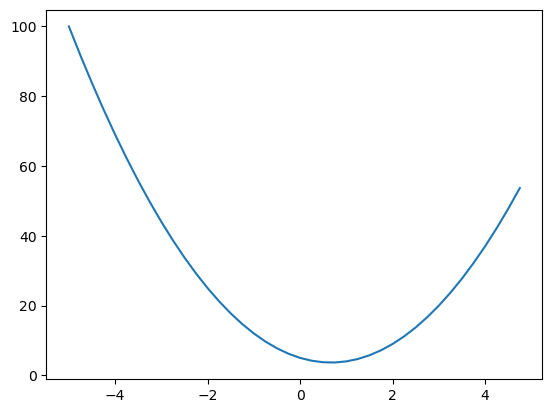

In [40]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [41]:
x = -1
h = 1e-8
(f(x+h) - f(x)) / h

-10.000000116860974

In [42]:
class Value:
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = _prev
        self._op = _op
        self.label = label
    
    def __str__(self):
        return f"Data={self.data}"
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def __sub__(self, other):
        out = Value(self.data - other.data)
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(n) - math.exp(-n)) / (math.exp(n) + math.exp(-n))
        out = Value(t, (self, ), 'tanh')
        return out

In [43]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a*b
c.label = 'c'


In [44]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{| label %s | data %.4f | grad %.4f |}" % ( n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

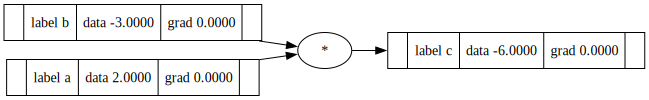

In [45]:
draw_dot(c)

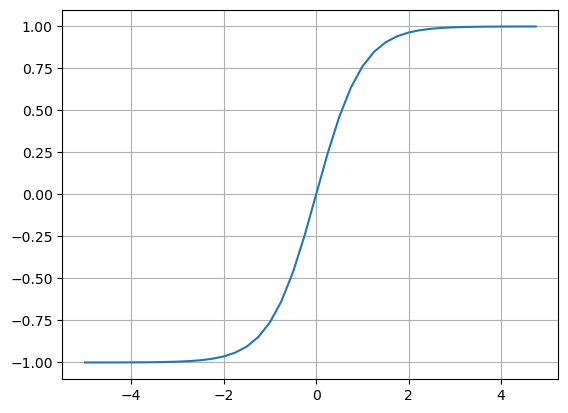

In [46]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)));plt.grid()

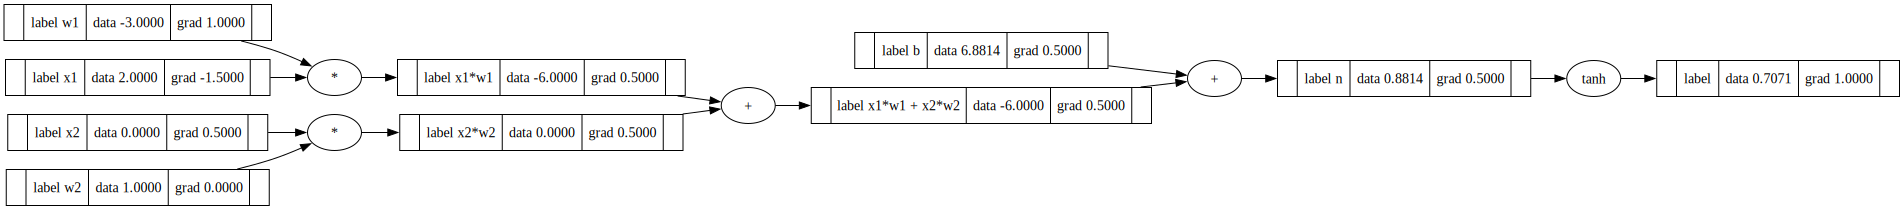

In [ ]:
#Basic neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

o.grad = 1
#derivative of tanh => 1 - tanh^2(x)
do_dn = 1 - o.data**2 
n.grad = do_dn

dn_dx1w1x2w2 = 1
dn_db = 1
x1w1x2w2.grad = do_dn * dn_dx1w1x2w2
b.grad = do_dn * dn_db

dx1w1x2w2_dx1w1 = 1
dx1w1x2w2_dx2w2 = 1
do_dx1w1 = do_dn * dn_dx1w1x2w2 * dx1w1x2w2_dx1w1
do_dx2w2 = do_dn * dn_dx1w1x2w2 * dx1w1x2w2_dx2w2
x1w1.grad = do_dx1w1
x2w2.grad = do_dx2w2

dx1w1_dx1 = w1.data
do_dx1 = do_dx1w1 * dx1w1_dx1
x1.grad = do_dx1

dx1w1_dw1 = x1.data
do_dw1 = do_dx1w1 * dx1w1_dw1
w1.grad = do_dw1

dx2w2_dx2 = w2.data
do_dx2 = do_dx2w2 * dx2w2_dx2
x2.grad = do_dx2

dx2w2_dw2 = x2.data
do_dw2 = do_dx2w2 * dx2w2_dw2
w2.grad = do_dw2

draw_dot(o)